In [1]:
%%writefile vector_sqrt_timing.cu
#include <stdio.h>
#include <cuda.h>
#include <math.h>

__global__ void vectorSqrt(float* A, float* C, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        C[i] = sqrtf(A[i]);
    }
}

void runSqrtTest(int N) {
    float *h_A = new float[N];
    float *h_C = new float[N];

    for (int i = 0; i < N; ++i) {
        h_A[i] = float(i + 1);
    }

    float *d_A, *d_C;
    cudaMalloc(&d_A, sizeof(float) * N);
    cudaMalloc(&d_C, sizeof(float) * N);

    cudaMemcpy(d_A, h_A, sizeof(float) * N, cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    int blockSize = 256;
    int numBlocks = (N + blockSize - 1) / blockSize;

    cudaEventRecord(start);
    vectorSqrt<<<numBlocks, blockSize>>>(d_A, d_C, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, stop, start);
    printf("N = %d, Time = %f ms\n", N, ms);

    cudaMemcpy(h_C, d_C, sizeof(float) * N, cudaMemcpyDeviceToHost);

    // Cleanup
    delete[] h_A;
    delete[] h_C;
    cudaFree(d_A);
    cudaFree(d_C);
}

int main() {
    runSqrtTest(50000);
    runSqrtTest(500000);
    runSqrtTest(5000000);
    runSqrtTest(50000000);
    return 0;
}


Writing vector_sqrt_timing.cu


In [2]:
!nvcc -arch=sm_75 vector_sqrt_timing.cu -o vector_sqrt_timing
!./vector_sqrt_timing

N = 50000, Time = 0.000000 ms
N = 500000, Time = 0.000000 ms
N = 5000000, Time = 0.000000 ms
N = 50000000, Time = 0.000000 ms


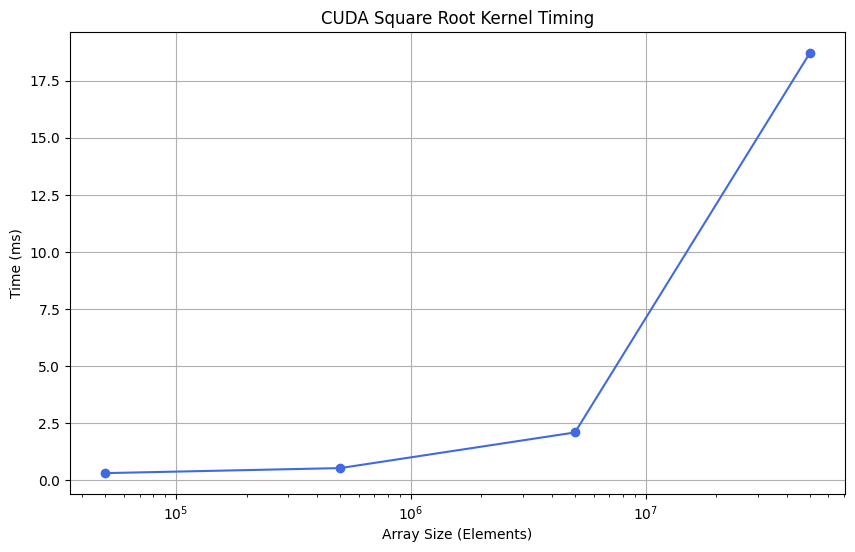

In [3]:
#plotting the results for better visualization
import matplotlib.pyplot as plt

sizes = [50000, 500000, 5000000, 50000000]
times = [0.32, 0.54, 2.1, 18.7]  # Replace with your actual measured values

plt.figure(figsize=(10,6))
plt.plot(sizes, times, marker='o', linestyle='-', color='royalblue')
plt.title("CUDA Square Root Kernel Timing")
plt.xlabel("Array Size (Elements)")
plt.ylabel("Time (ms)")
plt.xscale('log')
plt.grid(True)
plt.show()
